In [1]:
###Import
import glob
import timeit
import numpy as np
import cv2 as cv
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import copy
from matplotlib import colors
from math import pi
import os
import re


#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
import featexlib
from featexlib import Debug as dbug
from featexlib import *


plt.style.use('seaborn-whitegrid')

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

Totally 10 pair images found


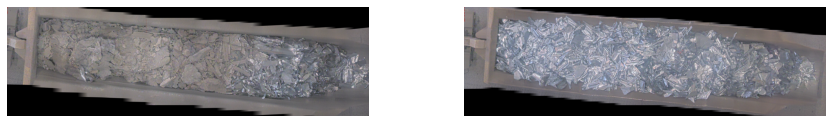

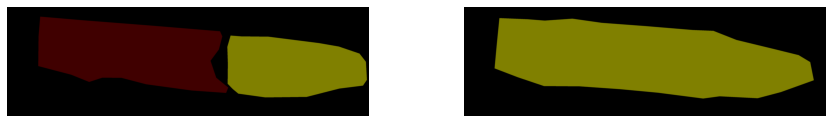

In [2]:
###ACTIVE CELL###
''' MOVED TO LIB
###Load images from folder for x and y simultaniously. Check if correspondig pair-image exists. With OpenCV reading mode options, name filtering and resizing.

def load_from_folders_xyy(save_dir_x = "Data/images/x", save_dir_y = "Data/images/y", file_filter_regex= r'' , size = None, cv_read_mode = cv.IMREAD_UNCHANGED):
    #Make y blob list
    list_of_files_y = {f:None for f in glob.glob(f"{save_dir_y}/*") if os.path.isfile(f)}  
    list_of_files_x = {f:re.search(file_filter_regex, f).group(1) for f in glob.glob(f"{save_dir_x}/*") if os.path.isfile(f) and re.search(file_filter_regex, f)}  
    
    #Find partner imeage x<->y
    for path_x, path_y in list_of_files_x.items():
        regex_y = r'/'+path_y+'\.\w+'
        find_result = [s for s in list_of_files_y if re.search(regex_y, s)]
        list_of_files_x[path_x] = find_result[0] if any(find_result) else None
        if any(find_result):
            list_of_files_y[find_result[0]]=1
    
    no_x_partner_list = [k for (k,v) in list_of_files_x.items() if v is None]
    no_y_partner_list = [k for (k,v) in list_of_files_y.items() if v is None]
    
    print('Totally %s pair images found'%(len(list_of_files_x)))
    
    if any(no_x_partner_list):
        print('WARNING: Following x has no y images:\n\r',no_x_partner_list)
    if any(no_y_partner_list):
        print('WARNING: Following y has no x images:\n\r',no_y_partner_list)
        
    #Old code
    
    #Generate dict{x:y}, check if x name exist in y folder. y may have different file extention
    #list_of_files_x = dict([
        
    #    (f,[i for i in list_of_files_y if re.search(r'/'+re.search(file_filter_regex, f).group(1)+'\.\w+', i)][0])
    #    if re.search(file_filter_regex, f) 
    #    and any(re.search(r'/'+re.search(file_filter_regex, f).group(1)+'\.\w+', s) for s in list_of_files_y) 
    #    and os.path.isfile(f)
    #    else (f, None)
    #    for f in glob.glob(f"{save_dir_x}/*") 
    #    ])         
    #list_of_files_x = {k:v for (k,v) in list_of_files_x.items() if v is not None}
    
    #Filter the result dict
    list_of_files_x = {k:v for (k,v) in list_of_files_x.items() if v is not None}
    
    out_x = np.array([ Image_generator.open_image(f, size=size, cv_read_mode=cv_read_mode) for f in list_of_files_x.keys()])
    out_y = np.array([ Image_generator.open_image(f, size=size, cv_read_mode=cv_read_mode) for f in list_of_files_x.values()])
    return out_x, out_y   
'''
###Prepare X dataset, reading from directory
images_x, images_y_raw = Image_generator.load_from_folders_xy(save_dir_x = "../../Data/scrapid/images_and_annotations/JPEGImages", 
                                           save_dir_y = "../../Data/scrapid/images_and_annotations/SegmentationClassPNG", 
                                           size=(3557,1071), 
                                           file_filter_regex = r'/([^/]+)\.jpg', 
                                           cv_read_mode = cv.IMREAD_COLOR)

dbug.show_images_list(images_x[:2,...,[2,1,0]], col_number = 2)
dbug.show_images_list(images_y_raw[:2,...,[2,1,0]], col_number = 2)

RGB decimal code is 8388736


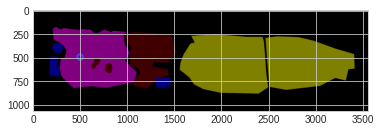

In [3]:
####FOR DEBUG###
###Find new color codes

#Help function to get decimal code of color
def rgb_to_dec(inp):
    return inp[0]*65536+inp[1]*256+inp[2]

###Put coords here
coords = (500,500)

#Select an image
pic = np.array(images_y_raw[9])

pic_c = cv.circle(pic, coords, 30, (250, 70, 70), 20)

dbug.show_image(pic_c[...,[2,1,0]])
print('RGB decimal code is', rgb_to_dec(pic[tuple(reversed(coords))]))

y shape (10, 1071, 3557, 7)


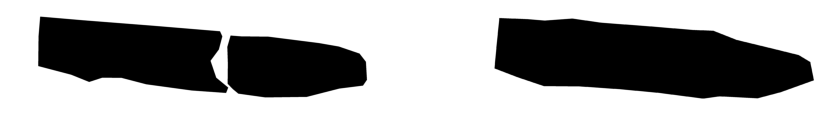

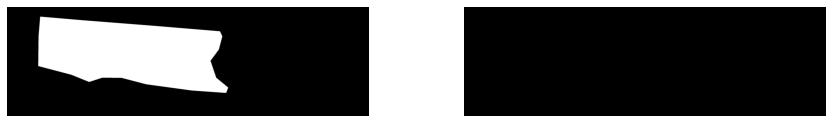

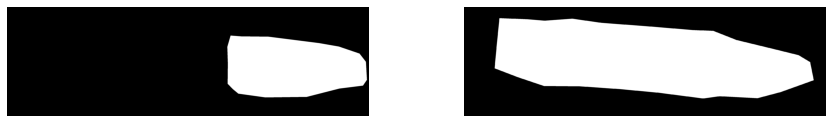

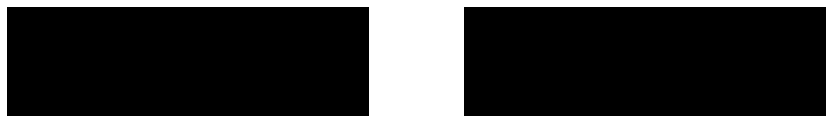

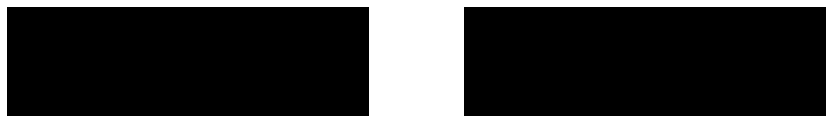

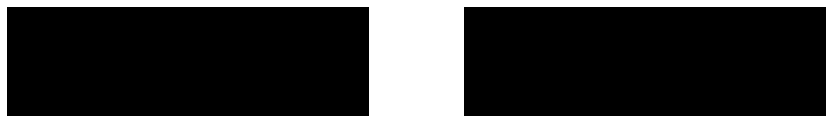

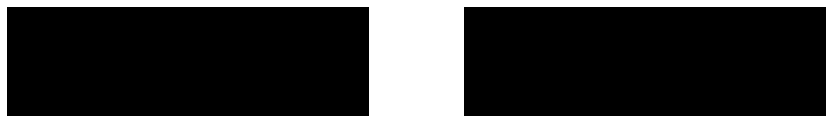

In [4]:
###ACTIVE CELL###
###Make multi class y array from multiclass image

#List of codes, do not change the order!
list_of_codes = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
]

#Make 1-hot coded y-multiarray from multiclass picture
def get_classes_from_multiclass(inp_y):
    y_colors = (inp_y[:,:,:,0]*65536+inp_y[:,:,:,1]*256+inp_y[:,:,:,2])[...,None]  
    out = []
    for c in list_of_codes:
        out.append((y_colors==c).astype(int)) 
    return np.concatenate(out, axis=3)

images_y = get_classes_from_multiclass(images_y_raw)

#Show some result
for c in range(len(list_of_codes)):
    dbug.show_images_list(images_y[:2,...,c], col_number = 2) 
    
print('y shape',images_y.shape)

x.shape = (10, 256, 768, 3) , y.shape = (10, 256, 768, 7)


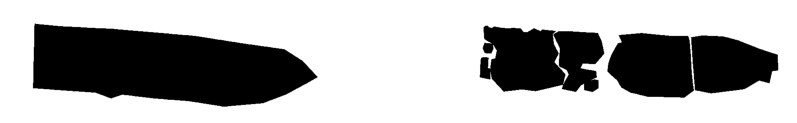

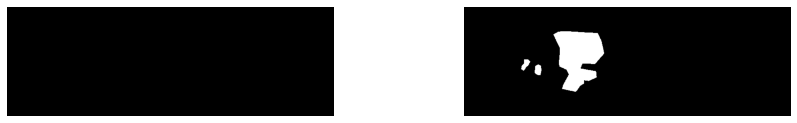

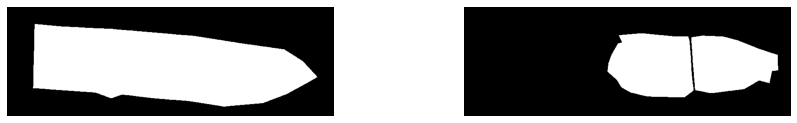

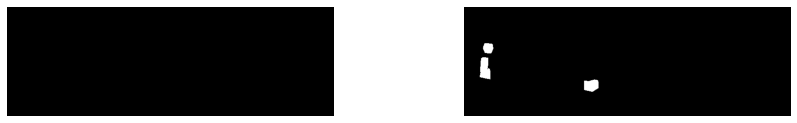

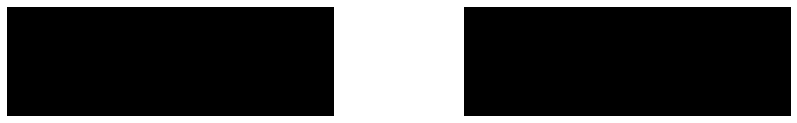

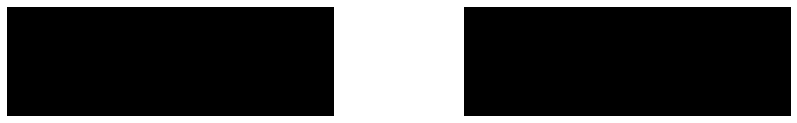

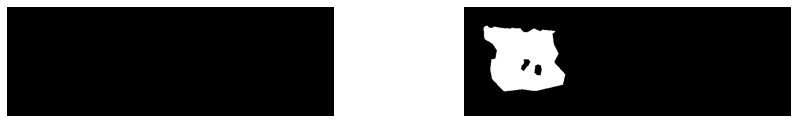

In [6]:
###ACTIVE CELL###
#Configure image generation pipeline, based on Image_generator class
bill_img_gen = Image_generator(
    Image_generator.Pipeline_x_y_images(
        common_layers = [
            #Image_generator.Mod_linear_transf(l=0.2, r=0.0, t = 0.2, b = 0.0, rand = False, target="all"),
            #Image_generator.Mod_add_padding(pl=2, pr=2, pt=2, pb=2, target="all"),
            #Image_generator.Mod_crop(t=0, l=0, h=500, w=500, target="all"),
            Image_generator.Mod_resize(size=(768,256), target="all", interpolation = cv.INTER_NEAREST)
            ###interpolation cv.INTER_NEAREST is required!!!!!
        ],
        special_layers = [[]]
    )
)

#Generate images. Run twice while need to export images_y_raw color images. TODO: optimisation
x_result, y_result = bill_img_gen(images_x, images_y)
_,        y_result_raw = bill_img_gen(images_x, images_y_raw)

#Show some result images
print('x.shape =',x_result.shape,',', 'y.shape =',y_result.shape)

#Show some result
for c in range(len(list_of_codes)):
    dbug.show_images_list(y_result[8:10,...,c], col_number = 2) 

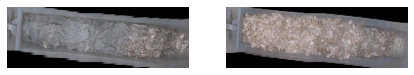

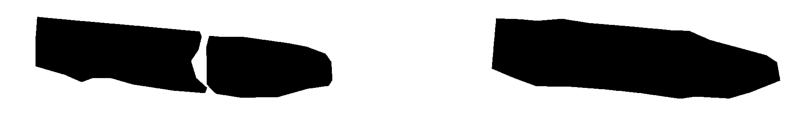

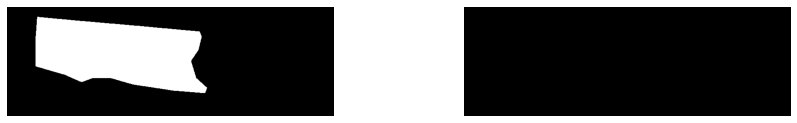

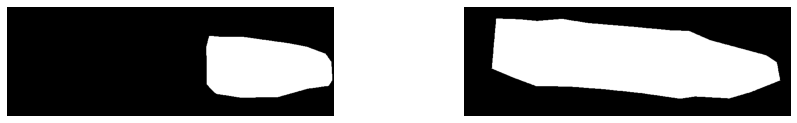

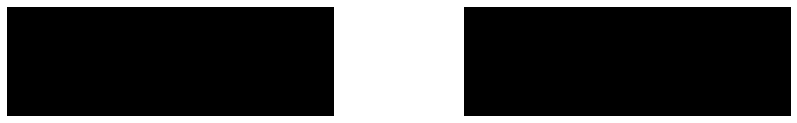

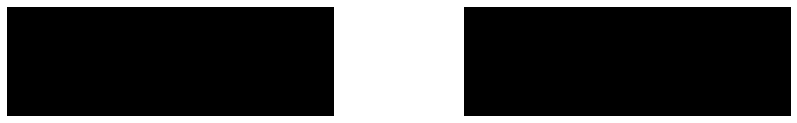

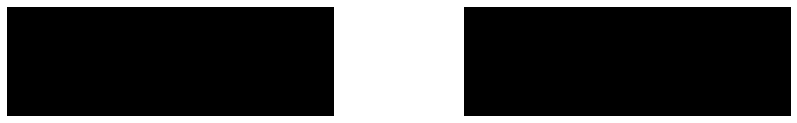

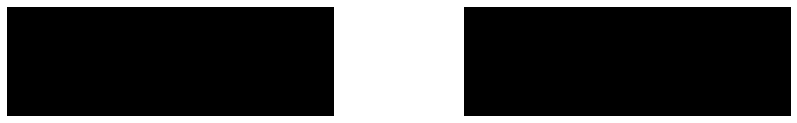

In [7]:
###ACTIVE CELL###
###Shuffle X and Y together

##IGNORE SHUFFLING BECAUSE EXPORTING Y MULTICOLOR IMAGES ALSO
x_result_shuff, y_result_shuff = x_result, y_result     #bill_img_gen.shuffle_x_y(x_result, y_result)

#Show some result images
dbug.show_images_list(x_result_shuff[:2], col_number = 4)
for c in range(len(list_of_codes)):
    dbug.show_images_list(y_result_shuff[:2,...,c], col_number = 2) 

In [17]:
###ACTIVE CELL###
###Save data to file
Image_generator.save_data(x_result_shuff, y_result_shuff, y_result_raw, save_dir = "../../Data/scrapid/training_data/", name="scrapid_7c_768x256_10_1")

x_load.shape = (10, 256, 768, 3) , y_load.shape = (10, 256, 768, 7)


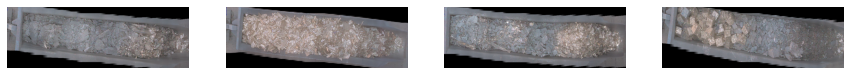

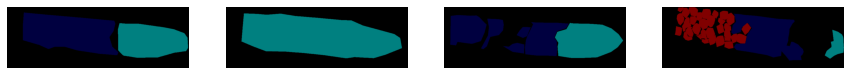

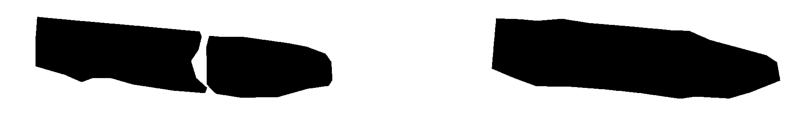

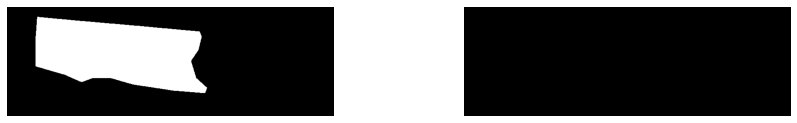

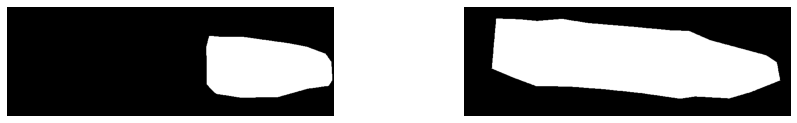

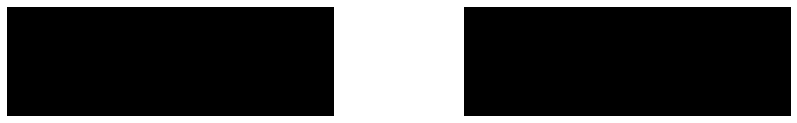

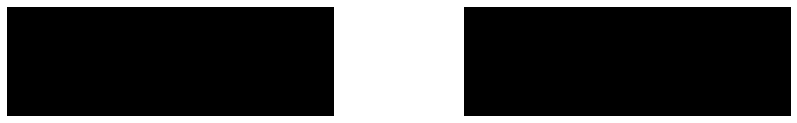

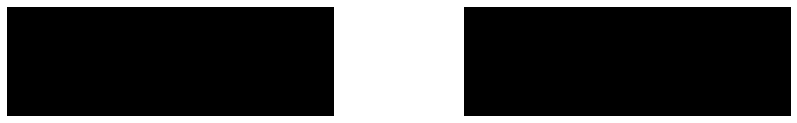

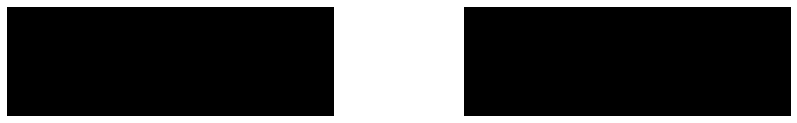

In [19]:
####TEST CELL#####
###Load data
###Testing that data has been saved and can be loaded

x_load, y_load , y_load_raw  = Image_generator.load_data(save_dir = "../../Data/scrapid/training_data/", name="scrapid_7c_768x256_10_1")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
dbug.show_images_list(x_load[:4], col_number = 4)
dbug.show_images_list(y_load_raw[:4], col_number = 4)
for c in range(y_load.shape[-1]):
    dbug.show_images_list(y_load[:2,...,c], col_number = 2) 